<a href="https://colab.research.google.com/github/LILPANDA-BYTE/STOCK_PREIDICTION_ANALYSIS/blob/main/FORECASTING_USING_TCN_and_WAVENET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install torch pytorch-forecasting pytorch-lightning
! pip install torchaudio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split

# Load and preprocess your data
file_path = '/content/drive/MyDrive/Forex_Data/DAT_ASCII_AUDCAD_M1_2007.csv'
headers = ['DateTime Stamp', 'Bar OPEN Bid Quote', 'Bar HIGH Bid Quote', 'Bar LOW Bid Quote', 'Bar CLOSE Bid Quote', 'Volume']
df = pd.read_csv(file_path, delimiter=";", names=headers)

# Convert the DateTime Stamp to datetime and sort
df['DateTime Stamp'] = pd.to_datetime(df['DateTime Stamp'])
df = df.sort_values('DateTime Stamp')

# Add features
df['log_volume'] = np.log(df['Volume'] + 1e-8)

# Define features and target
X = df[['Bar OPEN Bid Quote', 'Bar HIGH Bid Quote', 'Bar LOW Bid Quote', 'log_volume']].values
y = df['Bar CLOSE Bid Quote'].values

# Normalize features
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

# Split data into training and validation sets
train_size = int(0.8 * len(X))
val_size = len(X) - train_size
train_dataset, val_dataset = random_split(list(zip(X, y)), [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
import numpy as np

# Chomp1d class definition (if it isn't already defined)
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

# TemporalBlock class
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)

        # Downsample if needed
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None

        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

# TemporalConvNet class
class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# TCN class
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)

    def forward(self, x):
        y1 = self.tcn(x)
        o = self.linear(y1[:, :, -1])
        return o

# Instantiate model, criterion, optimizer
model = TCN(input_size=4, output_size=1, num_channels=[25, 50, 100], kernel_size=2, dropout=0.2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the training loop
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs):
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()

            # Ensure X_batch is 3D [batch_size, num_features, sequence_length]
            if X_batch.dim() == 2:
                X_batch = X_batch.unsqueeze(1)  # Add a dimension if missing

            output = model(X_batch.transpose(1, 2))  # Transpose to [batch_size, sequence_length, num_features]
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        val_losses = []
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:

                # Ensure X_batch is 3D [batch_size, num_features, sequence_length]
                if X_batch.dim() == 2:
                    X_batch = X_batch.unsqueeze(1)  # Add a dimension if missing

                output = model(X_batch.transpose(1, 2))
                loss = criterion(output, y_batch)
                val_losses.append(loss.item())

        print(f'Epoch {epoch+1}, Train Loss: {np.mean(train_losses)}, Val Loss: {np.mean(val_losses)}')

# Assuming you have the dataloaders `train_loader` and `val_loader`
train_model(model, criterion, optimizer, train_loader, val_loader, epochs=5)

Epoch 1, Train Loss: 0.006154929337303535, Val Loss: 4.942154199135693e-07
Epoch 2, Train Loss: 2.655359969068869e-05, Val Loss: 4.6057338315405967e-07
Epoch 3, Train Loss: 2.640627638933482e-06, Val Loss: 6.663484856752362e-07
Epoch 4, Train Loss: 4.030243963193754e-07, Val Loss: 1.0968519365462864e-06
Epoch 5, Train Loss: 2.012080878067834e-06, Val Loss: 3.9090363097852344e-08


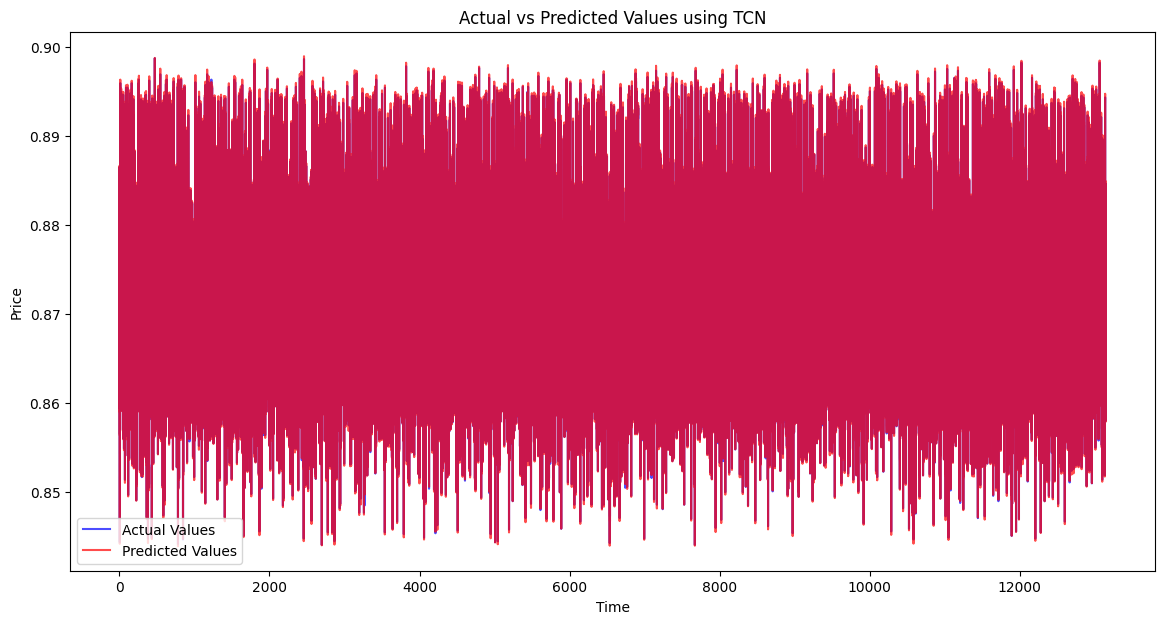

In [ ]:
model.eval()
with torch.no_grad():
    predictions = []
    actuals = []
    for X_batch, y_batch in val_loader:
        # Ensure X_batch is 3D [batch_size, num_features, sequence_length]
        if X_batch.dim() == 2:
            X_batch = X_batch.unsqueeze(1)  # Add a dimension if missing

        # Transpose to [batch_size, sequence_length, num_features] before passing to the model
        output = model(X_batch.transpose(1, 2))
        predictions.append(output.detach().numpy())
        actuals.append(y_batch.numpy())

predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

# Plot the predictions and actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(actuals, label='Actual Values', color='blue', alpha=0.7)
plt.plot(predictions, label='Predicted Values', color='red', alpha=0.7)
plt.title('Actual vs Predicted Values using TCN')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

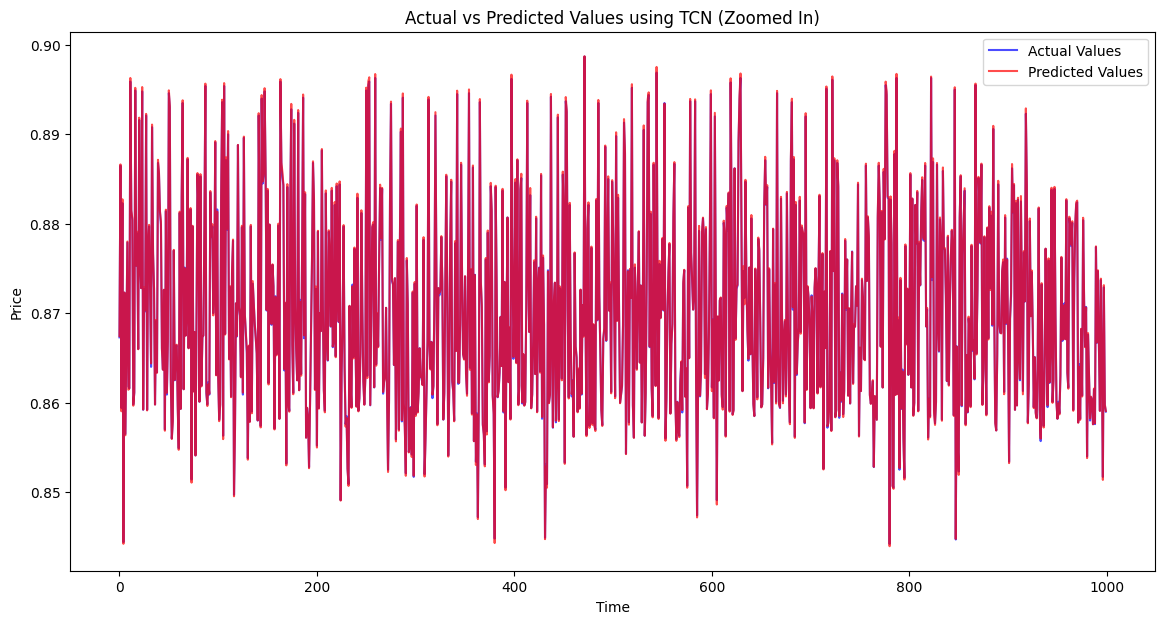

In [ ]:
# Plot the first 1000 data points for better visibility
plt.figure(figsize=(14, 7))
plt.plot(actuals[:1000], label='Actual Values', color='blue', alpha=0.7)
plt.plot(predictions[:1000], label='Predicted Values', color='red', alpha=0.7)
plt.title('Actual vs Predicted Values using TCN (Zoomed In)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

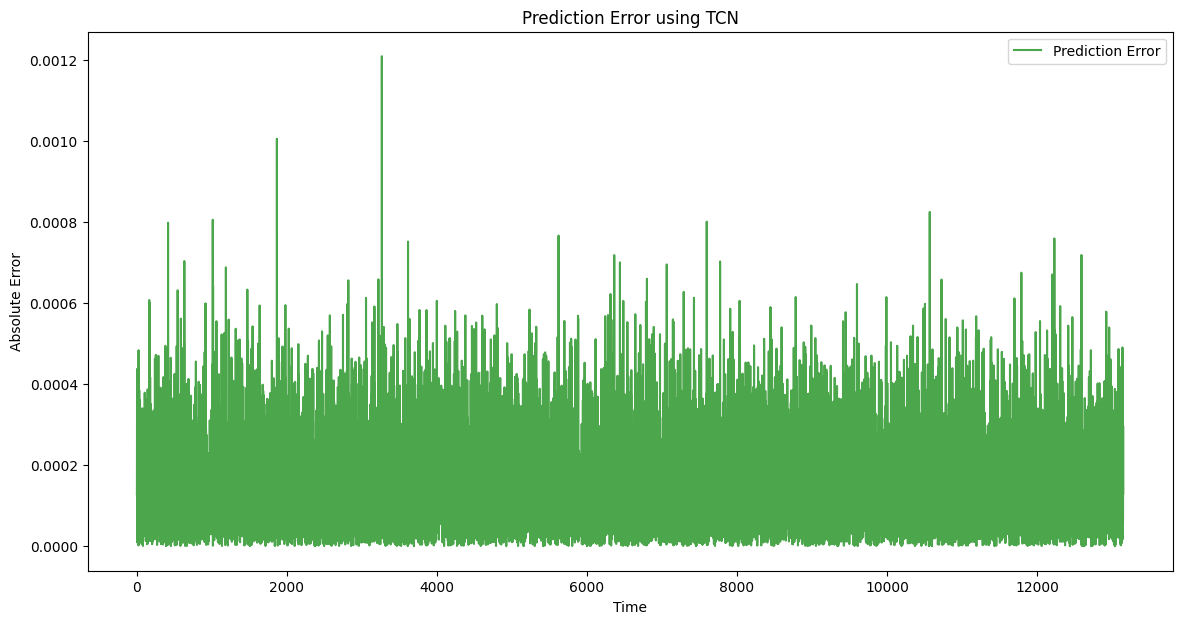

In [ ]:
errors = np.abs(predictions - actuals)
plt.figure(figsize=(14, 7))
plt.plot(errors, label='Prediction Error', color='green', alpha=0.7)
plt.title('Prediction Error using TCN')
plt.xlabel('Time')
plt.ylabel('Absolute Error')
plt.legend()
plt.show()

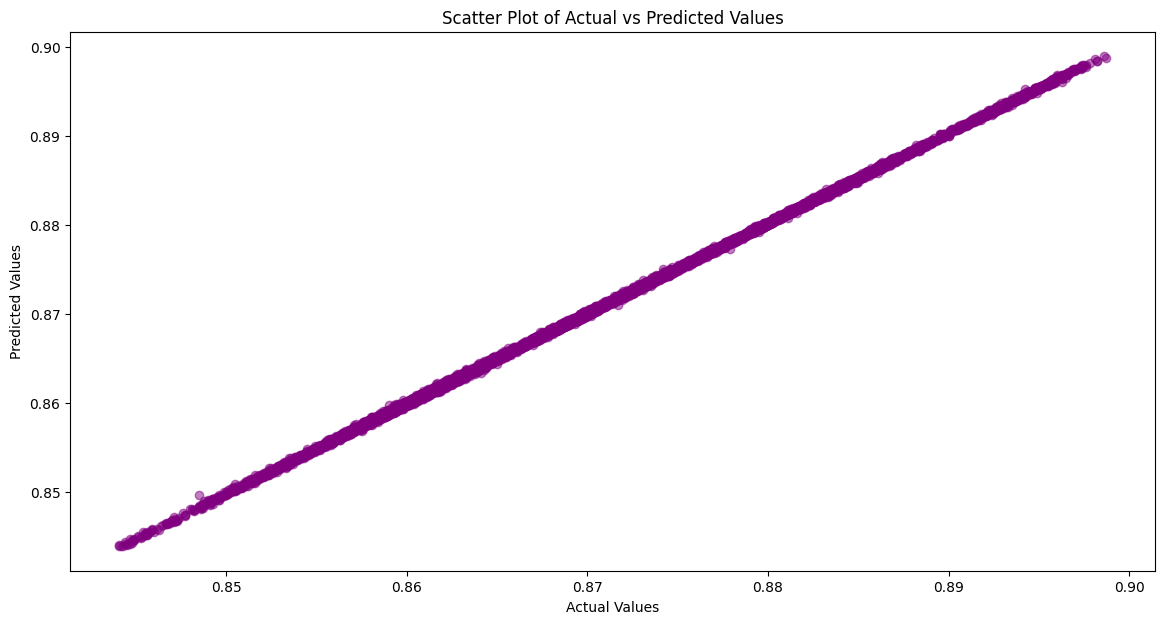

In [ ]:
plt.figure(figsize=(14, 7))
plt.scatter(actuals, predictions, alpha=0.5, color='purple')
plt.title('Scatter Plot of Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

USE

Epoch 1, Train Loss: 0.006002491940282383, Val Loss: 2.9664595876191395e-06
Epoch 2, Train Loss: 4.125592455103547e-05, Val Loss: 3.974295140027576e-06
Epoch 3, Train Loss: 5.7606305402972685e-06, Val Loss: 1.20787796353206e-07
Epoch 4, Train Loss: 9.333337607036593e-07, Val Loss: 1.0415997765862801e-06
Epoch 5, Train Loss: 1.1811840760681962e-06, Val Loss: 1.3432778601060647e-06
Test Loss: 1.3352514493261288e-06


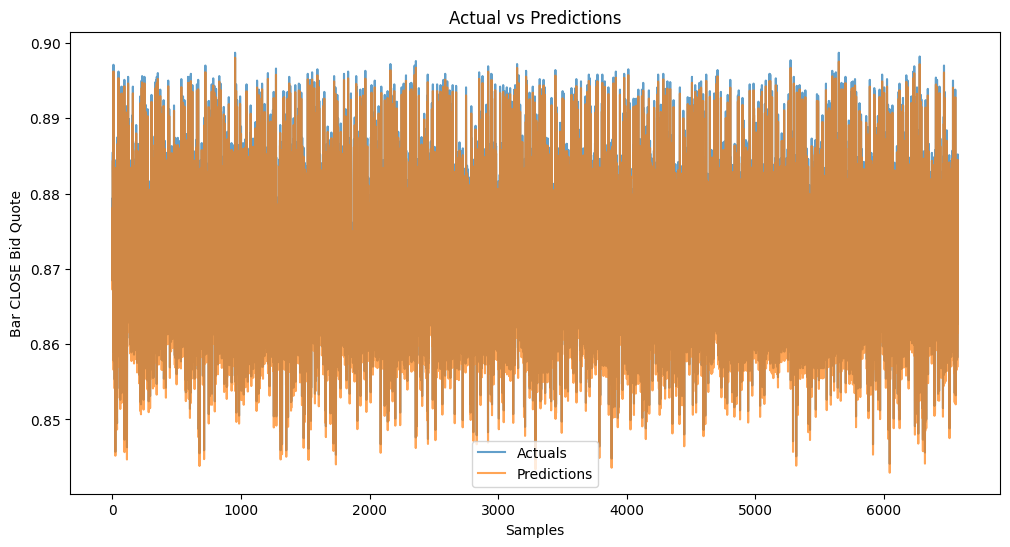

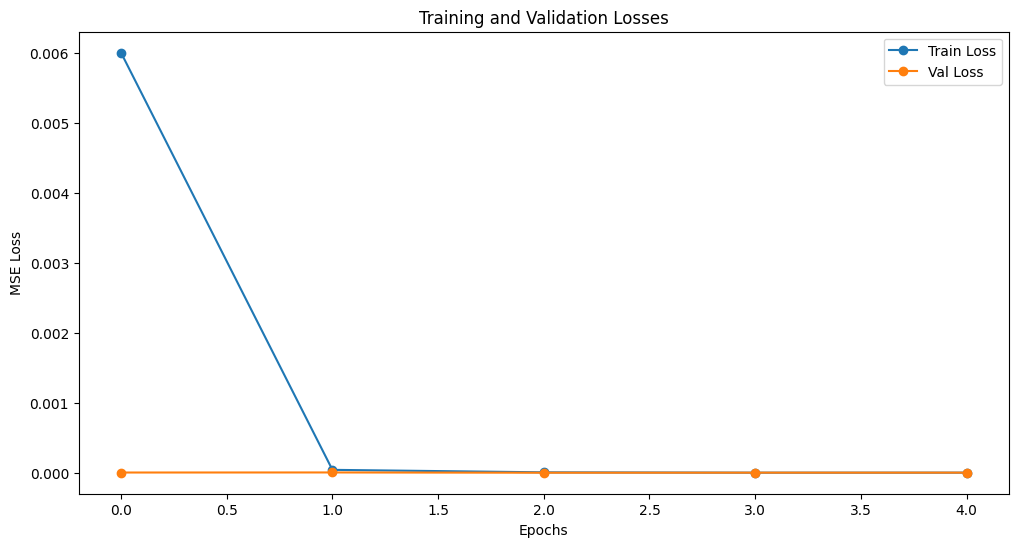

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt

# Load and preprocess your data
file_path = '/content/drive/MyDrive/Forex_Data/DAT_ASCII_AUDCAD_M1_2007.csv'
headers = ['DateTime Stamp', 'Bar OPEN Bid Quote', 'Bar HIGH Bid Quote', 'Bar LOW Bid Quote', 'Bar CLOSE Bid Quote', 'Volume']
df = pd.read_csv(file_path, delimiter=";", names=headers)

# Convert the DateTime Stamp to datetime and sort
df['DateTime Stamp'] = pd.to_datetime(df['DateTime Stamp'])
df = df.sort_values('DateTime Stamp')

# Add features
df['log_volume'] = np.log(df['Volume'] + 1e-8)

# Define features and target
X = df[['Bar OPEN Bid Quote', 'Bar HIGH Bid Quote', 'Bar LOW Bid Quote', 'log_volume']].values
y = df['Bar CLOSE Bid Quote'].values

# Normalize features
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)

# Split data into training, validation, and test sets
train_size = int(0.7 * len(X))
val_size = int(0.2 * len(X))
test_size = len(X) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(list(zip(X, y)), [train_size, val_size, test_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define Chomp1d class
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

# Define TemporalBlock class
class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)

        # Downsample if needed
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None

        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

# Define TemporalConvNet class
class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Define TCN class
class TCN(nn.Module):
    def __init__(self, input_size, output_size, num_channels, kernel_size, dropout):
        super(TCN, self).__init__()
        self.tcn = TemporalConvNet(input_size, num_channels, kernel_size=kernel_size, dropout=dropout)
        self.linear = nn.Linear(num_channels[-1], output_size)

    def forward(self, x):
        y1 = self.tcn(x)
        o = self.linear(y1[:, :, -1])
        return o

# Instantiate model, criterion, optimizer
model = TCN(input_size=4, output_size=1, num_channels=[25, 50, 100], kernel_size=2, dropout=0.2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Define the training loop
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        batch_train_losses = []
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()

            # Ensure X_batch is 3D [batch_size, num_features, sequence_length]
            if X_batch.dim() == 2:
                X_batch = X_batch.unsqueeze(1)  # Add a dimension if missing

            output = model(X_batch.transpose(1, 2))  # Transpose to [batch_size, sequence_length, num_features]
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            batch_train_losses.append(loss.item())

        train_losses.append(np.mean(batch_train_losses))

        model.eval()
        batch_val_losses = []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:

                # Ensure X_batch is 3D [batch_size, num_features, sequence_length]
                if X_batch.dim() == 2:
                    X_batch = X_batch.unsqueeze(1)  # Add a dimension if missing

                output = model(X_batch.transpose(1, 2))
                loss = criterion(output, y_batch)
                batch_val_losses.append(loss.item())

        val_losses.append(np.mean(batch_val_losses))

        print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}')

    return train_losses, val_losses

# Training the model
epochs = 5
train_losses, val_losses = train_model(model, criterion, optimizer, train_loader, val_loader, epochs)

# Testing the model
def test_model(model, criterion, test_loader):
    model.eval()
    test_losses = []
    actuals = []
    predictions = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            if X_batch.dim() == 2:
                X_batch = X_batch.unsqueeze(1)  # Add a dimension if missing

            output = model(X_batch.transpose(1, 2))
            loss = criterion(output, y_batch)
            test_losses.append(loss.item())

            actuals.extend(y_batch.numpy())
            predictions.extend(output.numpy())

    print(f'Test Loss: {np.mean(test_losses)}')
    return actuals, predictions

# Evaluate the model on the test set
actuals, predictions = test_model(model, criterion, test_loader)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actuals', alpha=0.7)
plt.plot(predictions, label='Predictions', alpha=0.7)
plt.legend()
plt.title('Actual vs Predictions')
plt.xlabel('Samples')
plt.ylabel('Bar CLOSE Bid Quote')
plt.show()

# Plotting training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='o')
plt.legend()
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.show()

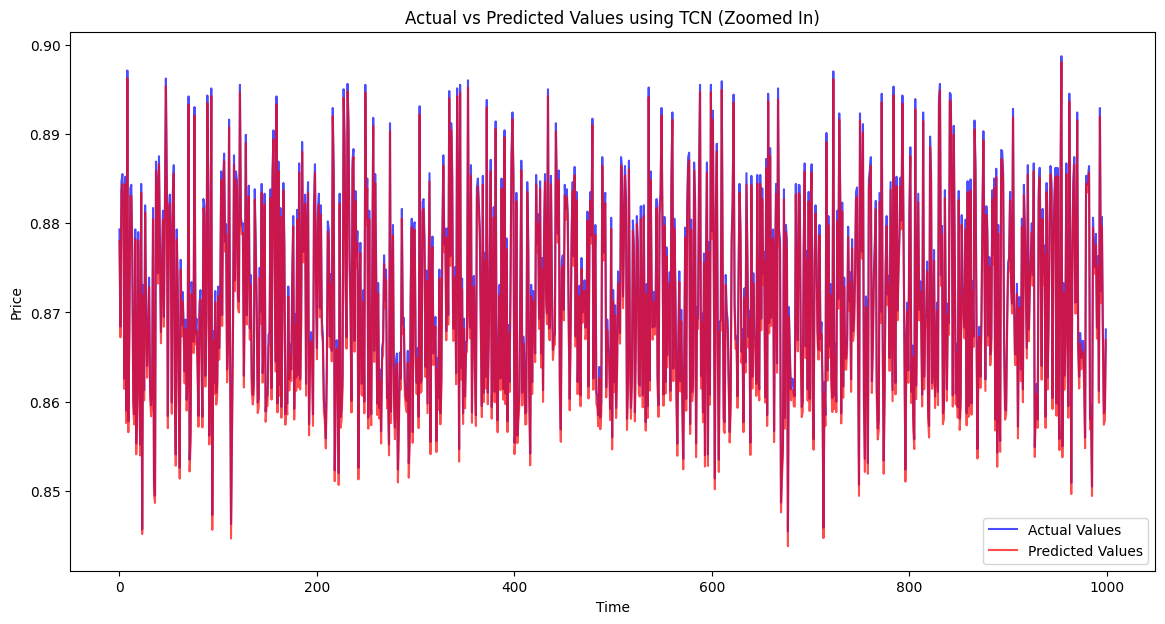

In [ ]:
# Plot the first 1000 data points for better visibility
plt.figure(figsize=(14, 7))
plt.plot(actuals[:1000], label='Actual Values', color='blue', alpha=0.7)
plt.plot(predictions[:1000], label='Predicted Values', color='red', alpha=0.7)
plt.title('Actual vs Predicted Values using TCN (Zoomed In)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

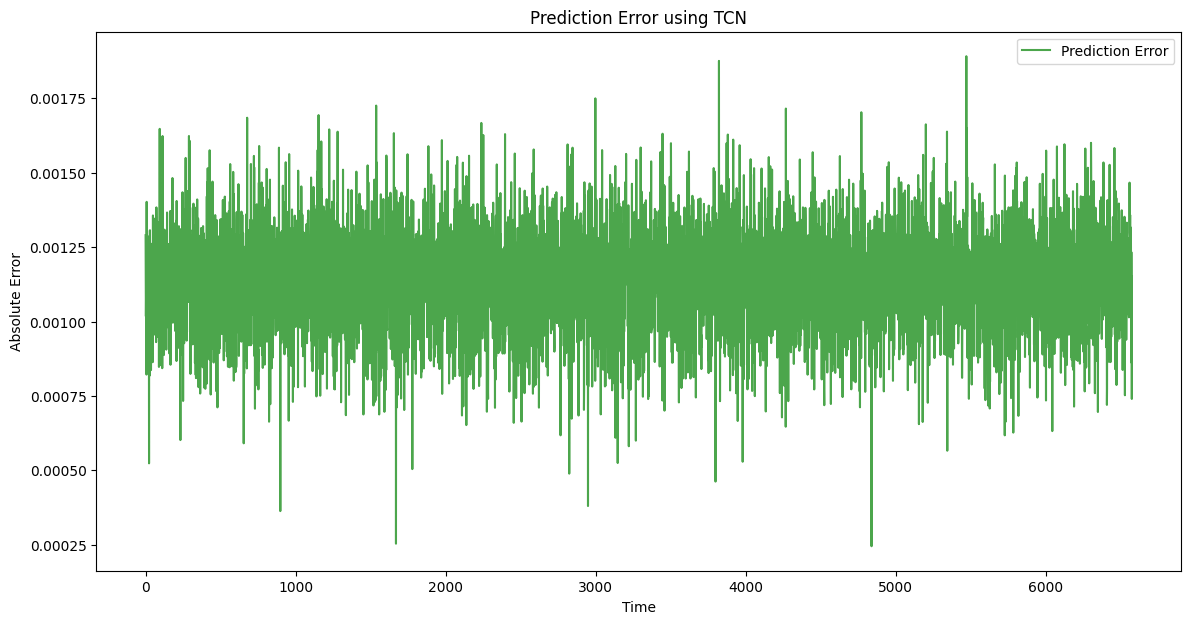

In [ ]:
# Convert lists to NumPy arrays for element-wise operations
predictions = np.array(predictions)
actuals = np.array(actuals)

errors = np.abs(predictions - actuals)  # Now this should work

plt.figure(figsize=(14, 7))
plt.plot(errors, label='Prediction Error', color='green', alpha=0.7)
plt.title('Prediction Error using TCN')
plt.xlabel('Time')
plt.ylabel('Absolute Error')
plt.legend()
plt.show()

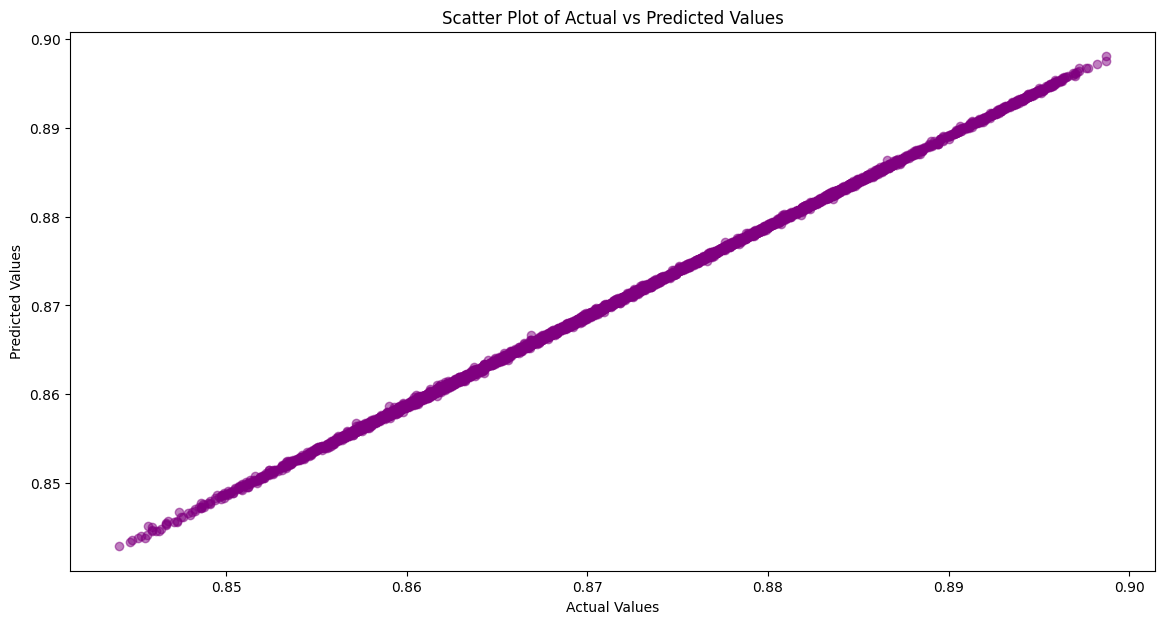

In [ ]:
plt.figure(figsize=(14, 7))
plt.scatter(actuals, predictions, alpha=0.5, color='purple')
plt.title('Scatter Plot of Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

WAVENET

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CausalConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(CausalConv1d, self).__init__()
        self.causal_conv = nn.Conv1d(in_channels, out_channels, kernel_size,
                                     padding=(kernel_size - 1) * dilation, dilation=dilation)

    def forward(self, x):
        return self.causal_conv(x)[:, :, :-self.causal_conv.padding[0]]

class WaveNet(nn.Module):
    def __init__(self, in_channels, out_channels, num_layers, kernel_size, residual_channels):
        super(WaveNet, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_layers = num_layers

        self.start_conv = nn.Conv1d(in_channels, residual_channels, kernel_size=1)
        self.residual_layers = nn.ModuleList()
        self.skip_layers = nn.ModuleList()

        for i in range(num_layers):
            dilation = 2 ** i
            self.residual_layers.append(
                CausalConv1d(residual_channels, residual_channels, kernel_size, dilation)
            )
            self.skip_layers.append(nn.Conv1d(residual_channels, out_channels, kernel_size=1))

        self.end_conv1 = nn.Conv1d(out_channels, out_channels, kernel_size=1)
        self.end_conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.start_conv(x)
        skip_connections = 0

        for i in range(self.num_layers):
            residual = self.residual_layers[i](x)
            skip = self.skip_layers[i](residual)
            skip_connections += skip
            x = F.relu(residual + x)

        x = F.relu(skip_connections)
        x = self.end_conv1(x)
        x = F.relu(x)
        x = self.end_conv2(x)

        return x

In [ ]:
# Instantiate the model
input_size = 4  # Number of input features
output_size = 1  # Predicting one value (Bar CLOSE Bid Quote)
num_layers = 10  # Number of residual layers
kernel_size = 2  # Size of the kernel
residual_channels = 32  # Number of residual channels

model = WaveNet(in_channels=input_size, out_channels=output_size,
                num_layers=num_layers, kernel_size=kernel_size,
                residual_channels=residual_channels)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, criterion, optimizer, train_loader, val_loader, epochs):
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()

            # Ensure X_batch is 3D [batch_size, num_features, sequence_length]
            if X_batch.dim() == 2:
                X_batch = X_batch.unsqueeze(1)  # Add a dimension if missing

            output = model(X_batch.transpose(1, 2))  # Transpose to [batch_size, sequence_length, num_features]
            loss = criterion(output[:, :, -1], y_batch)  # Predict the last value in the sequence
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        val_losses = []
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in val_loader:

                # Ensure X_batch is 3D [batch_size, num_features, sequence_length]
                if X_batch.dim() == 2:
                    X_batch = X_batch.unsqueeze(1)  # Add a dimension if missing

                output = model(X_batch.transpose(1, 2))
                loss = criterion(output[:, :, -1], y_batch)
                val_losses.append(loss.item())

        print(f'Epoch {epoch+1}, Train Loss: {np.mean(train_losses)}, Val Loss: {np.mean(val_losses)}')

# Assuming you have the dataloaders `train_loader` and `val_loader`
train_model(model, criterion, optimizer, train_loader, val_loader, epochs=5)

Epoch 1, Train Loss: 0.18304274751707042, Val Loss: 0.0029199213784305866
Epoch 2, Train Loss: 0.00041912657621250596, Val Loss: 0.00012697145002078347
Epoch 3, Train Loss: 0.00012639402021737115, Val Loss: 0.00012696398398541527
Epoch 4, Train Loss: 0.00012642025101031588, Val Loss: 0.0001270509211986933
Epoch 5, Train Loss: 0.00012644860551067915, Val Loss: 0.00012702896143805458


Test Loss: 0.00012494529073592275


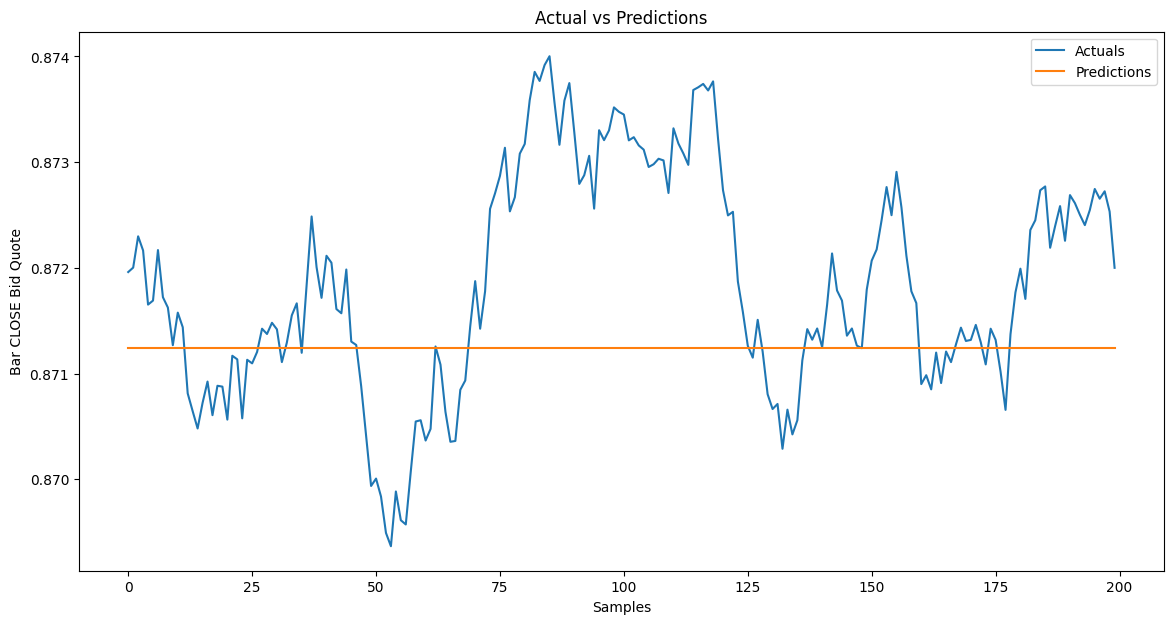

In [ ]:
# Function to evaluate the model on the test set
def test_model(model, criterion, test_loader):
    model.eval()
    actuals = []
    predictions = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:

            if X_batch.dim() == 2:
                X_batch = X_batch.unsqueeze(1)

            output = model(X_batch.transpose(1, 2))
            predictions.append(output[:, :, -1].cpu().numpy())
            actuals.append(y_batch.cpu().numpy())

    actuals = np.concatenate(actuals, axis=0)
    predictions = np.concatenate(predictions, axis=0)
    test_loss = criterion(torch.tensor(predictions), torch.tensor(actuals))
    print(f'Test Loss: {test_loss.item()}')
    return actuals, predictions

# Function to plot the results
def plot_results(actuals, predictions, subset_size=200, window_size=50):
    """
    Plots the actual vs predicted values.

    :param actuals: Array of actual values
    :param predictions: Array of predicted values
    :param subset_size: Number of samples to plot
    :param window_size: Size of the moving average window
    """
    # Ensure actuals and predictions are 1D arrays
    actuals = np.array(actuals).flatten()
    predictions = np.array(predictions).flatten()

    # Optionally, you can smooth the predictions using a moving average
    if window_size > 1:
        predictions_smoothed = np.convolve(predictions, np.ones(window_size)/window_size, mode='valid')
        actuals_smoothed = np.convolve(actuals, np.ones(window_size)/window_size, mode='valid')
    else:
        predictions_smoothed = predictions
        actuals_smoothed = actuals

    # Plot a subset of the data
    plt.figure(figsize=(14, 7))
    plt.plot(actuals_smoothed[:subset_size], label='Actuals')
    plt.plot(predictions_smoothed[:subset_size], label='Predictions')
    plt.xlabel('Samples')
    plt.ylabel('Bar CLOSE Bid Quote')
    plt.title('Actual vs Predictions')
    plt.legend()
    plt.show()

# Evaluate and plot results
actuals, predictions = test_model(model, criterion, test_loader)
plot_results(actuals, predictions, subset_size=200, window_size=50)